# 数据分析案例：纽约市出租车数据集
纽约市出租车数据集记录了黄色出租车的详细行程信息，包括上车和下车时间、乘客数量、行程距离及费用等。这些数据通常用来分析出租车的使用情况、交通模式、乘客行为等，我们将使用 dask 进行比较完整的数据分析实战案例。


In [6]:
import os

new_directory = "/home/u2022201752/scale-py-zh"
os.chdir(new_directory)

import matplotlib.pyplot as plt
from utils import nyc_taxi
import dask.dataframe as dd

taxi_path = nyc_taxi()

我们先读取数据。纽约市出租车数据集由多个Parquet文件组成，每个文件对应一个月份，dask 可以用通配符`*`直接读取多个Parquet文件，

In [27]:
ddf = dd.read_parquet(os.path.join(taxi_path, "*.parquet"))

ddf.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00



下面我们研究每种费率类型`RatecodeID`对总费用`total_amount`的影响。我们对数据先进行预处理。

In [28]:
ddf = ddf.dropna(subset=['total_amount', 'RatecodeID'])

# 转换数据类型
ddf['tpep_pickup_datetime'] = dd.to_datetime(ddf['tpep_pickup_datetime'])
ddf['tpep_dropoff_datetime'] = dd.to_datetime(ddf['tpep_dropoff_datetime'])

我们使用`groupby()`进行分组并求均值。值得一提的是，由于 dask 惰性求值的特性，在进行操作后要使用`compute()`来触发执行。

不同费率类型的平均总费用:
RatecodeID
1.0      24.593968
2.0      89.125251
3.0     113.776517
4.0     125.120810
5.0      82.161150
6.0      60.408966
99.0     37.100776
Name: total_amount, dtype: float64


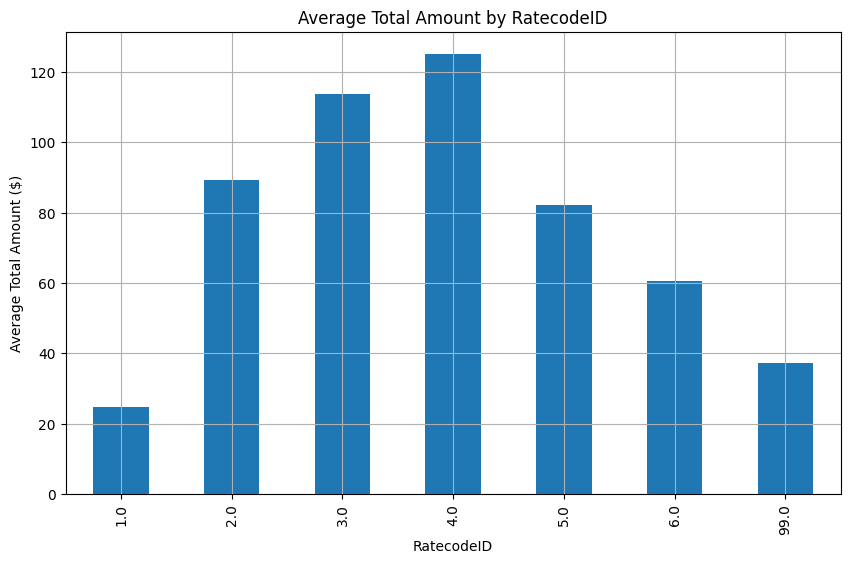

In [29]:
# 按照 RatecodeID 分组，分析每种费率类型的平均总费用
avg_amount_by_ratecode = ddf.groupby('RatecodeID')['total_amount'].mean().compute()

print("不同费率类型的平均总费用:")
print(avg_amount_by_ratecode)

# 可视化
plt.figure(figsize=(10, 6))
avg_amount_by_ratecode.plot(kind='bar')
plt.xlabel('RatecodeID')
plt.ylabel('Average Total Amount ($)')
plt.title('Average Total Amount by RatecodeID')
plt.grid(True)
plt.show()